# **Image Classification: Using Transformer**
> By Mohit Kothari - 101411645 and Anisha Singla - 101411015

# Approach : Transfer Learning - using State of the art: Xception Transformer by Keras. 
### Here, we will be using a pre-trained object classification model, and then we will finetune it to classify:

*   Species of flowers (from 5 classes)
*   Type of Car (from 196 classes)

### First, we will classify the flower images, then we will use another dataset with different features from flowers to check and compare the performance of the pre-trained model on two completely different datasets. So we decided to use the Cars dataset, and let's check the result.


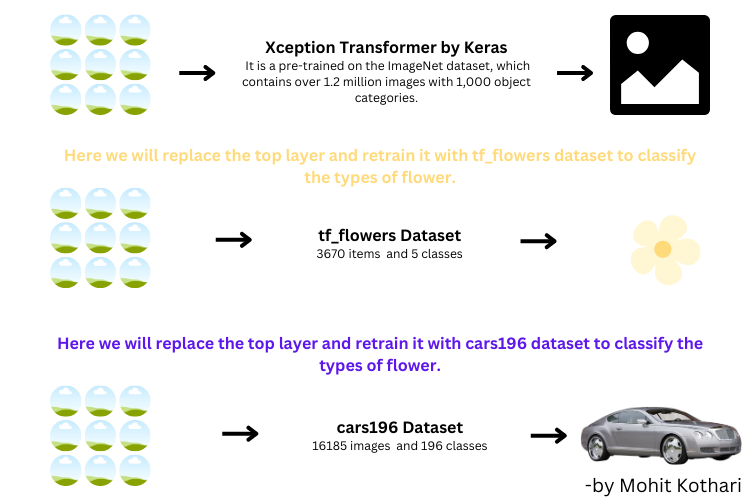

# Working:
##### We will get rid off the top layer of the pretrained model and finetune existing model (i.e retrain it) with the new specialized dataset.  

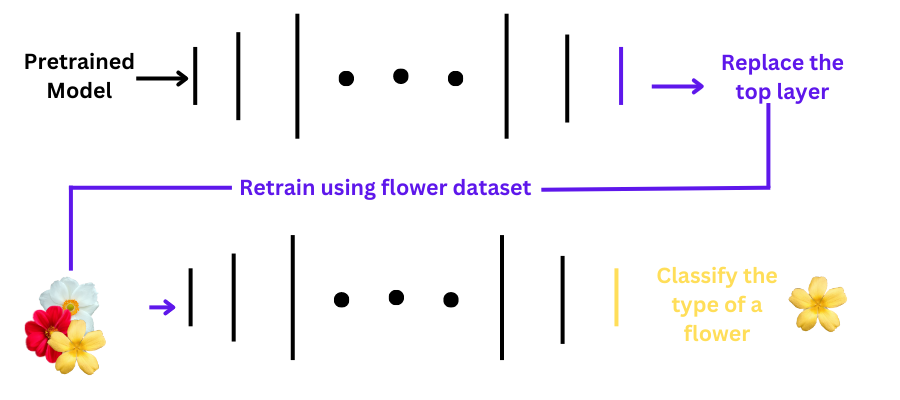

-by Mohit Kothari





# Problem Statement:

##### **Deep learning has a terrible carbon footprint.**
> https://rb.gy/d0uf

##### According to this article: **Training a single AI model can emit as much carbon as five cars in their lifetimes.**
##### There is a way to reduce the carbon footprint of training machine learning models, and it's called **transfer learning**. Not only does it address carbon emissions, but it also addresses the issue of limited data. 
> In our case, we only have a few thousand images in our target dataset. To address this, we can use a pre-trained transformer model that has been trained on millions of images. This approach can help us achieve good performance with a complex architecture.


### **Detailed Technical Explanation**
##### Specifically, we'll use **transfer learning** with the Xception model, which has been pre-trained on a large dataset to extract useful features from images. This way, we can effectively utilize the pre-trained model to improve the performance of our target model. 

### **A. Flowers**

### 1. Importing libraries
> Why are we using Tensorflow Dataset?
> Because, TensorFlow Datasets exposes a variety public research datasets with a uniform API yielding. Along with this, its simplicity and performance can achieve state-of-the-art speed.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

### 2. Loading the dataset

In [2]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1.incompleteQXIJPX',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info. features["label"].num_classes

In [5]:
print("Total number of images in the dataset: ", dataset_size)

Total number of images in the dataset:  3670


In [6]:
print("There are",n_classes,"classes in the dataset, and those are as follows: ")
for c in class_names:
  print(c)

There are 5 classes in the dataset, and those are as follows: 
dandelion
daisy
tulips
sunflowers
roses


### 3. Train, Test, and Validation split

In [7]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers", split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

### 4. Preprocessing

In [8]:
def preprocess(image,label):
    resized_image = tf.image.resize(image, [224,224])     #resising all the images to make input images of the same size.
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


In [9]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)

#Running all the three set of dataset through preprocessing function.
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

### 5. This is where all the magic is happening (means **Transfer Learning**)

In [10]:
# Top layer consists of average pooling and output layer. So we are removing the top layer
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

#And here we are creating our own average pooling and output layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

#Combining those layers to create our model with new top layer.
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


### 6. Freezing the base model layers
##### Which means the base model parameters won't be touched. those parameters won't be updated. The only parameters that need to be updated are the ones that we created in previous cell.

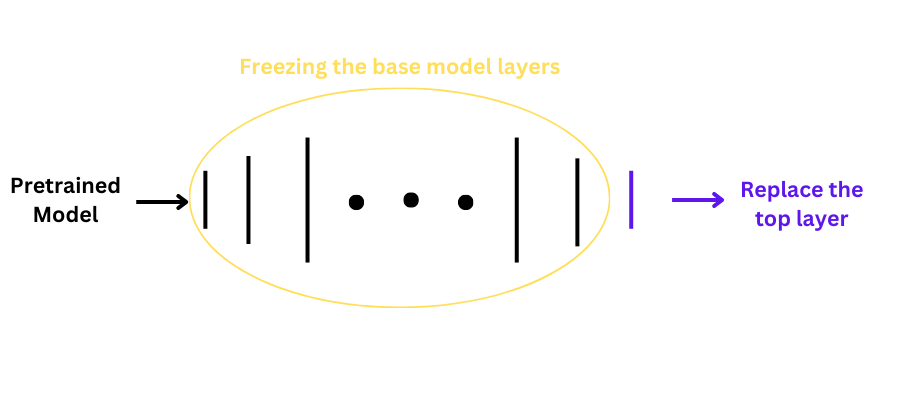

-by Mohit Kothari

In [11]:
for layer in base_model.layers:
  layer.trainable = False

### 6.a. Model Compilation and Finetuning

In [12]:
# Keeping learning rate quite high becuase we want last two layers to learn as quck as possible.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_set, epochs=16, validation_data=valid_set)

Epoch 1/16
86/86 [==============================] - 33s 194ms/step - loss: 1.3378 - accuracy: 0.7845 - val_loss: 1.7702 - val_accuracy: 0.8276
Epoch 2/16
86/86 [==============================] - 13s 152ms/step - loss: 0.9438 - accuracy: 0.8746 - val_loss: 1.3342 - val_accuracy: 0.8639
Epoch 3/16
86/86 [==============================] - 13s 153ms/step - loss: 0.5411 - accuracy: 0.9164 - val_loss: 1.2450 - val_accuracy: 0.8421
Epoch 4/16
86/86 [==============================] - 13s 151ms/step - loss: 0.2532 - accuracy: 0.9440 - val_loss: 1.5748 - val_accuracy: 0.8330
Epoch 5/16
86/86 [==============================] - 14s 158ms/step - loss: 0.2723 - accuracy: 0.9473 - val_loss: 1.3230 - val_accuracy: 0.8621
Epoch 6/16
86/86 [==============================] - 14s 159ms/step - loss: 0.1011 - accuracy: 0.9713 - val_loss: 1.2037 - val_accuracy: 0.8603
Epoch 7/16
86/86 [==============================] - 14s 159ms/step - loss: 0.0827 - accuracy: 0.9771 - val_loss: 1.4275 - val_accuracy: 0.8258


### 6.b. Accuracy/Loss graphical representation of top layer

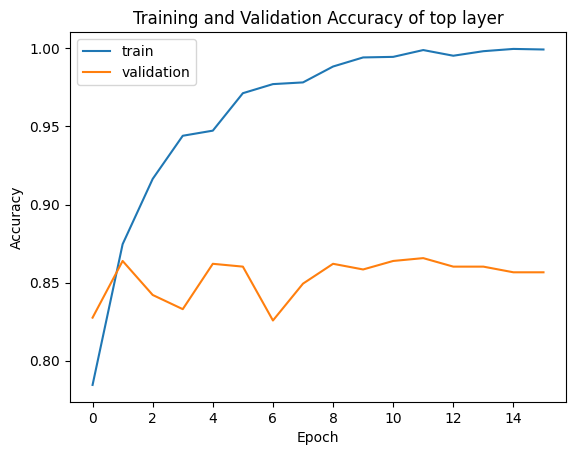

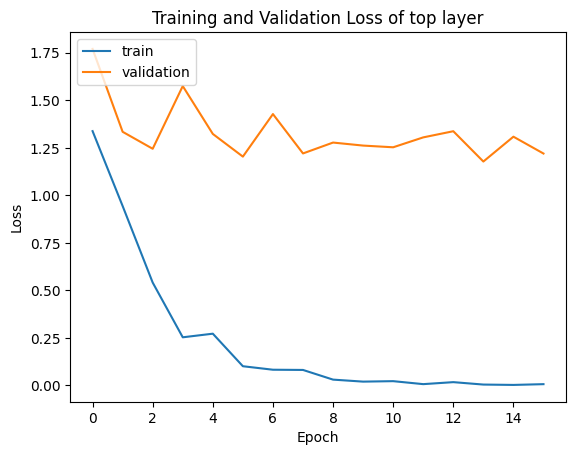

In [13]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy and loss from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('Training and Validation Accuracy of top layer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Training and Validation Loss of top layer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

> After a couple of epochs we haven't made much progress in terms of validation loss and accuracy. Longer we train, our top layer will start performing well as compared to rest of the model. So, we might need to train model holistically a little bit (for some epochs, less number of epochs comapred to the top layer). That's why we unfreezing the top layer and retraining the entire model.

### 7. Unfreezing the model
##### After training the top layer, now we will train enitre model holisticly. 

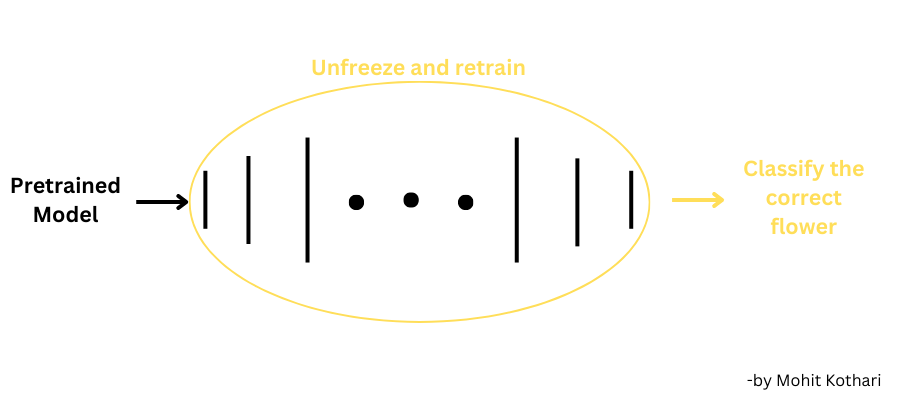

In [14]:
for layer in base_model.layers:
  layer.trainable = True

### 7.a. Recompiling the model

In [15]:
#Keeping learning rate low this time as we don't want to mess with the parameters of base model. As we have added new parameters, we also want to keep previous parameters untouched evn after transfer learning.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_set, epochs=8, validation_data=valid_set)

Epoch 1/8
86/86 [==============================] - 73s 599ms/step - loss: 0.5189 - accuracy: 0.8408 - val_loss: 0.9245 - val_accuracy: 0.8149
Epoch 2/8
86/86 [==============================] - 49s 575ms/step - loss: 0.1433 - accuracy: 0.9542 - val_loss: 0.3573 - val_accuracy: 0.9056
Epoch 3/8
86/86 [==============================] - 48s 562ms/step - loss: 0.0476 - accuracy: 0.9833 - val_loss: 0.3186 - val_accuracy: 0.9238
Epoch 4/8
86/86 [==============================] - 50s 583ms/step - loss: 0.0402 - accuracy: 0.9884 - val_loss: 0.2856 - val_accuracy: 0.9147
Epoch 5/8
86/86 [==============================] - 50s 577ms/step - loss: 0.0246 - accuracy: 0.9913 - val_loss: 0.3566 - val_accuracy: 0.9238
Epoch 6/8
86/86 [==============================] - 48s 563ms/step - loss: 0.0130 - accuracy: 0.9953 - val_loss: 0.3049 - val_accuracy: 0.9256
Epoch 7/8
86/86 [==============================] - 50s 582ms/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.3558 - val_accuracy: 0.9201
Epoch 

### 7.b. Accuray/Loss graphical representation of New model

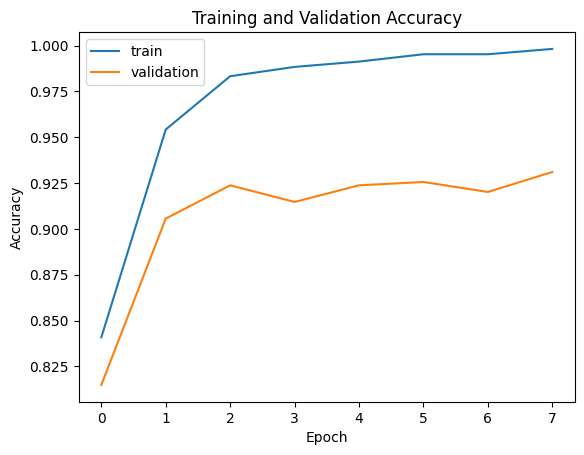

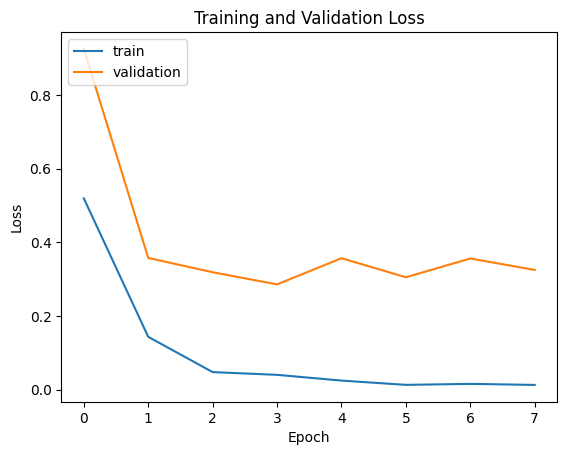

In [16]:

# Get the training and validation accuracy and loss from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


> **Note: Here, our approach will be the same. The only thing that changes is the dataset.**

# **B. Cars**

# Working

##### We will get rid off the top layer of the pretrained layer and finetune existing model (i.e retrain it) with the new specialized dataset.

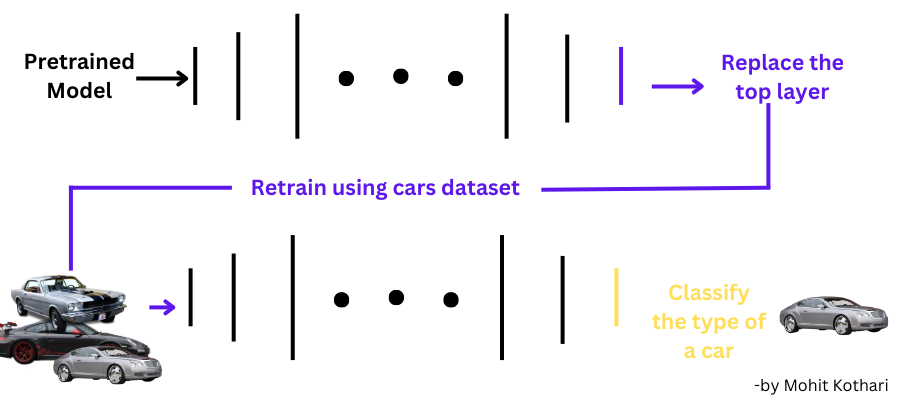

### 1. Already imported all the required libraries 

### 2. Loading the dataset

In [17]:
dataset_c, info_c = tfds.load("cars196", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incomplete4GDO3J/cars196-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incomplete4GDO3J/cars196-test.tfrecord*...:   0%|          |…

Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.1.0. Subsequent calls will reuse this data.


In [18]:
info_c

tfds.core.DatasetInfo(
    name='cars196',
    full_name='cars196/2.1.0',
    description="""
    The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.
    """,
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    data_path='/root/tensorflow_datasets/cars196/2.1.0',
    file_format=tfrecord,
    download_size=1.82 GiB,
    dataset_size=1.85 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=196),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=8

### 3. Extracting Metadata

In [19]:
dataset_size_c = info_c.splits["train"].num_examples + info_c.splits["test"].num_examples
class_names_c = info_c.features["label"].names
n_classes_c = info_c.features["label"].num_classes

In [20]:
print("Total number of images in the dataset: ", dataset_size_c)

Total number of images in the dataset:  16185


In [21]:
print("There are",n_classes_c,"classes in the dataset, and those are as follows: ")
for c in class_names_c:
  print(c)

There are 196 classes in the dataset, and those are as follows: 
AM General Hummer SUV 2000
Acura RL Sedan 2012
Acura TL Sedan 2012
Acura TL Type-S 2008
Acura TSX Sedan 2012
Acura Integra Type R 2001
Acura ZDX Hatchback 2012
Aston Martin V8 Vantage Convertible 2012
Aston Martin V8 Vantage Coupe 2012
Aston Martin Virage Convertible 2012
Aston Martin Virage Coupe 2012
Audi RS 4 Convertible 2008
Audi A5 Coupe 2012
Audi TTS Coupe 2012
Audi R8 Coupe 2012
Audi V8 Sedan 1994
Audi 100 Sedan 1994
Audi 100 Wagon 1994
Audi TT Hatchback 2011
Audi S6 Sedan 2011
Audi S5 Convertible 2012
Audi S5 Coupe 2012
Audi S4 Sedan 2012
Audi S4 Sedan 2007
Audi TT RS Coupe 2012
BMW ActiveHybrid 5 Sedan 2012
BMW 1 Series Convertible 2012
BMW 1 Series Coupe 2012
BMW 3 Series Sedan 2012
BMW 3 Series Wagon 2012
BMW 6 Series Convertible 2007
BMW X5 SUV 2007
BMW X6 SUV 2012
BMW M3 Coupe 2012
BMW M5 Sedan 2010
BMW M6 Convertible 2010
BMW X3 SUV 2012
BMW Z4 Convertible 2012
Bentley Continental Supersports Conv. Convertib

### 4. Train, Test, and Validatin split of the Data

> As we can see from the info, dataset is already split almost in two equal halves. This might create sampling bias, underfitting or overfitting. So to avoid these most likely problems, and for fair comparison, we will be using train dataset for now.

In [22]:
test_set_raw_c, valid_set_raw_c, train_set_raw_c = tfds.load("tf_flowers", split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

### 5. Preprocessing

In [23]:
def preprocess(image,label):
    resized_image_c = tf.image.resize(image, [224,224])     #resising all the images to make input images of the same size.
    final_image_c = tf.keras.applications.xception.preprocess_input(resized_image_c)
    return final_image_c, label


In [24]:
batch_size = 32
train_set_c = train_set_raw_c.shuffle(1000)

#Running all the three set of dataset through preprocessing function.
train_set_c = train_set_c.map(preprocess).batch(batch_size).prefetch(1)
valid_set_c = valid_set_raw_c.map(preprocess).batch(batch_size).prefetch(1)
test_set_c = test_set_raw_c.map(preprocess).batch(batch_size).prefetch(1)

### 6.This is where the magic will happen again (**Transfer Learning**)

In [25]:
# Top layer consists of average pooling and output layer. So we are removing the top layer
base_model_c = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

#And here we are creating our own average pooling and output layer
avg_c = tf.keras.layers.GlobalAveragePooling2D()(base_model_c.output)
output_c = tf.keras.layers.Dense(n_classes, activation="softmax")(avg_c)

#Combining those layers to create our model with new top layer.
model_c = tf.keras.Model(inputs=base_model_c.input, outputs=output_c)

### 7.Freezing the base model
##### Which means the base model parameters won't be touched. those parameters won't be updated. The only parameters that need to be updated are the ones that we created in previous cell.


In [26]:
for layer in base_model_c.layers:
  layer.trainable = False

### 7.a. Model compilation and Finetuning 

In [27]:
# Keeping learning rate quite high becuase we want last two layers to learn as quck as possible.
optimizer_c = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)

model_c.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_c, metrics=["accuracy"])

history_c = model_c.fit(train_set_c, epochs=16, validation_data=valid_set_c)

Epoch 1/16
86/86 [==============================] - 19s 167ms/step - loss: 1.5835 - accuracy: 0.7856 - val_loss: 1.7213 - val_accuracy: 0.8221
Epoch 2/16
86/86 [==============================] - 13s 156ms/step - loss: 1.0093 - accuracy: 0.8739 - val_loss: 1.0903 - val_accuracy: 0.8548
Epoch 3/16
86/86 [==============================] - 14s 164ms/step - loss: 0.6056 - accuracy: 0.9139 - val_loss: 1.1958 - val_accuracy: 0.8766
Epoch 4/16
86/86 [==============================] - 14s 165ms/step - loss: 0.3579 - accuracy: 0.9302 - val_loss: 1.2619 - val_accuracy: 0.8675
Epoch 5/16
86/86 [==============================] - 15s 169ms/step - loss: 0.3143 - accuracy: 0.9397 - val_loss: 1.4597 - val_accuracy: 0.8711
Epoch 6/16
86/86 [==============================] - 15s 172ms/step - loss: 0.1400 - accuracy: 0.9713 - val_loss: 1.4365 - val_accuracy: 0.8548
Epoch 7/16
86/86 [==============================] - 14s 167ms/step - loss: 0.0821 - accuracy: 0.9793 - val_loss: 1.2380 - val_accuracy: 0.8784

### 7.b. Accuracy/Loss graphical representation of top layer

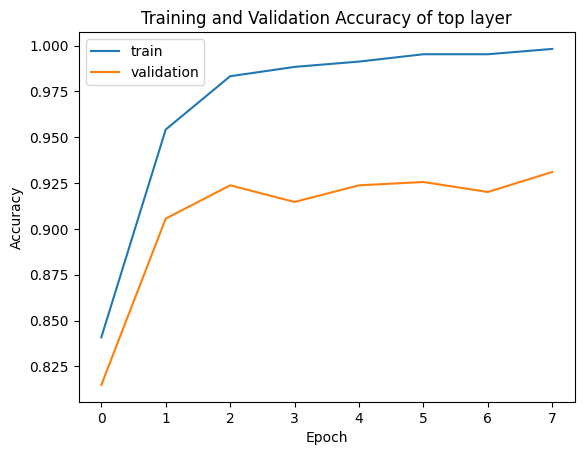

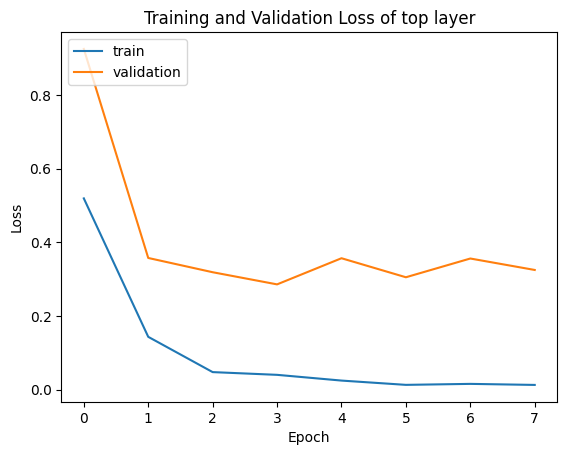

In [28]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy and loss from the history object
training_accuracy_c = history.history['accuracy']
validation_accuracy_c = history.history['val_accuracy']
training_loss_c = history.history['loss']
validation_loss_c = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(training_accuracy_c)
plt.plot(validation_accuracy_c)
plt.title('Training and Validation Accuracy of top layer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(training_loss_c)
plt.plot(validation_loss_c)
plt.title('Training and Validation Loss of top layer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 8.Unfreezing the model
##### After training the top layer, now we will train entire model holisticly

In [29]:
for layer in base_model_c.layers:
  layer.trainable = True

### 8.a. Recompiling the model

In [30]:
#Keeping learning rate low this time as we don't want to mess with the parameters of base model. As we have added new parameters, we also want to keep previous parameters untouched evn after transfer learning.
optimizer_c = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_c.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_c, metrics=["accuracy"])

history_c = model_c.fit(train_set_c, epochs=8, validation_data=valid_set_c)

Epoch 1/8
86/86 [==============================] - 65s 591ms/step - loss: 0.4596 - accuracy: 0.8554 - val_loss: 0.6854 - val_accuracy: 0.8457
Epoch 2/8
86/86 [==============================] - 50s 578ms/step - loss: 0.1145 - accuracy: 0.9637 - val_loss: 0.3086 - val_accuracy: 0.9183
Epoch 3/8
86/86 [==============================] - 48s 560ms/step - loss: 0.0387 - accuracy: 0.9902 - val_loss: 0.3256 - val_accuracy: 0.9074
Epoch 4/8
86/86 [==============================] - 50s 582ms/step - loss: 0.0211 - accuracy: 0.9938 - val_loss: 0.3700 - val_accuracy: 0.9129
Epoch 5/8
86/86 [==============================] - 49s 574ms/step - loss: 0.0085 - accuracy: 0.9964 - val_loss: 0.3576 - val_accuracy: 0.9074
Epoch 6/8
86/86 [==============================] - 48s 562ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.4392 - val_accuracy: 0.9038
Epoch 7/8
86/86 [==============================] - 50s 581ms/step - loss: 0.0209 - accuracy: 0.9931 - val_loss: 0.3865 - val_accuracy: 0.9165
Epoch 

### 8.b. Accuracy/Loss graphical representaion of a new model.

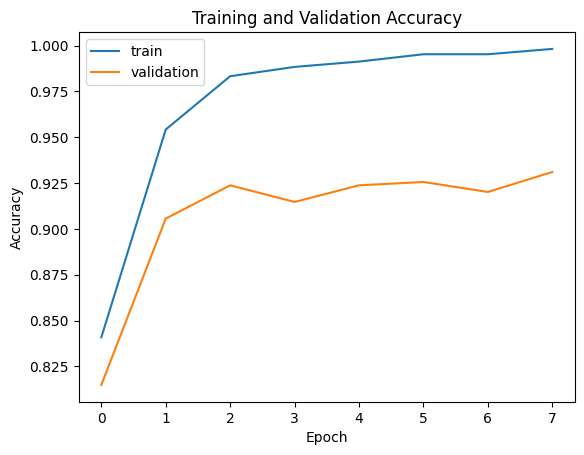

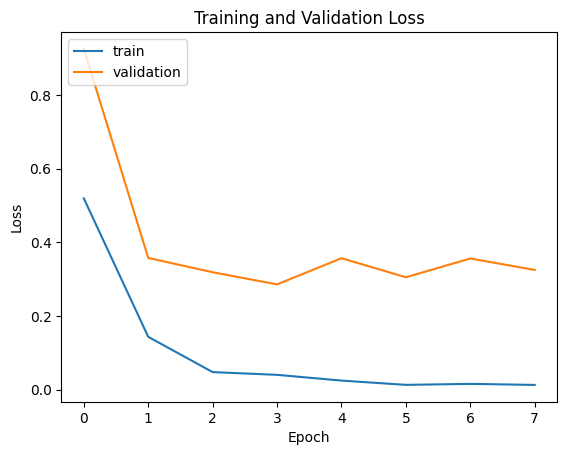

In [31]:
# Get the training and validation accuracy and loss from the history object
training_accuracy_c = history.history['accuracy']
validation_accuracy_c = history.history['val_accuracy']
training_loss_c = history.history['loss']
validation_loss_c = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(training_accuracy_c)
plt.plot(validation_accuracy_c)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(training_loss_c)
plt.plot(validation_loss_c)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Conclusion:
### After using transfer learning approach, we can conclude that:


1. Saved a lot of time: Since our transformer has already been trained on millions of images, it has already learned a lot of features from the large dataset.
2. Less Hardeare utilization. Means less Carbon Emission.
3. It gave better performance even on small dataset. And Performance was better with the car dataset as compared to flower, as we have more images and features of cars. 

# Reference:
https://www.youtube.com/watch?v=DyPW-994t7w

We took initial idea from this youtube video, and developed our model on top of this idea.

# Project 2 - Extension 

> Here, as an extension we are implementing transfer learning with **MobileNet** pre-trained model.

> Why MobileNet?
> Because, it is a mobile first class of CNN architecture that is much faster as well as a smaller model that makes use of a new kind of convolutional layer, known as Depthwise Separable convolution

> As name suggests, it is suitable to deploy our model to mobile application.

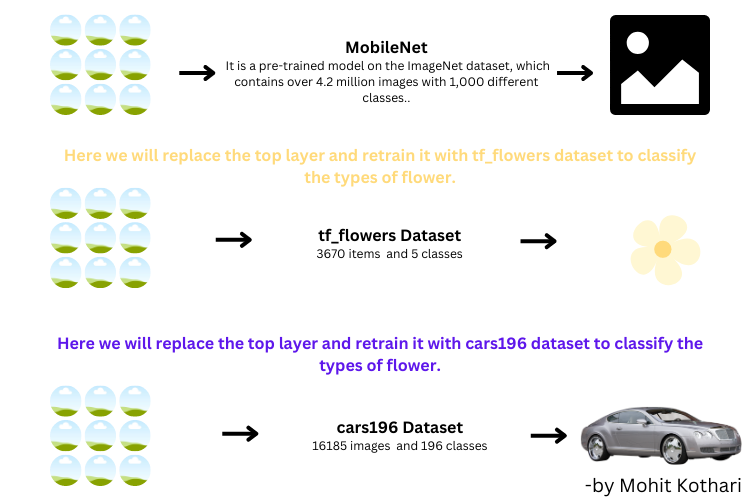

# Approach : Transfer Learning - using State of the art: Xception Transformer by Keras. 
### Here, our approach will be the same. Only thing that changes, is Model. 

### 2.A Importing the model

In [36]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

### Magical Part (**Transfer Learning**)

In [37]:
# And a little bit different coding approach
# Load the MobileNet model, pre-trained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.4, momentum=0.7)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train the model
history = model.fit(train_set, epochs=16, validation_data=valid_set)


Epoch 1/16
86/86 [==============================] - 7s 47ms/step - loss: 7.0854 - accuracy: 0.7725 - val_loss: 3.2369 - val_accuracy: 0.8784
Epoch 2/16
86/86 [==============================] - 3s 39ms/step - loss: 1.8517 - accuracy: 0.9015 - val_loss: 3.8667 - val_accuracy: 0.8457
Epoch 3/16
86/86 [==============================] - 3s 40ms/step - loss: 1.2107 - accuracy: 0.9299 - val_loss: 3.6123 - val_accuracy: 0.8657
Epoch 4/16
86/86 [==============================] - 4s 46ms/step - loss: 0.9739 - accuracy: 0.9353 - val_loss: 3.0627 - val_accuracy: 0.8730
Epoch 5/16
86/86 [==============================] - 4s 42ms/step - loss: 0.5142 - accuracy: 0.9578 - val_loss: 2.8129 - val_accuracy: 0.8784
Epoch 6/16
86/86 [==============================] - 7s 82ms/step - loss: 0.3241 - accuracy: 0.9738 - val_loss: 3.6151 - val_accuracy: 0.8657
Epoch 7/16
86/86 [==============================] - 4s 42ms/step - loss: 0.2297 - accuracy: 0.9778 - val_loss: 3.0239 - val_accuracy: 0.8875
Epoch 8/16
86

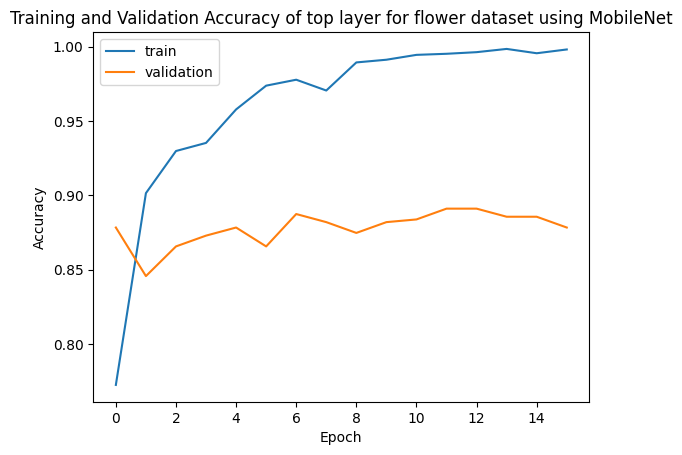

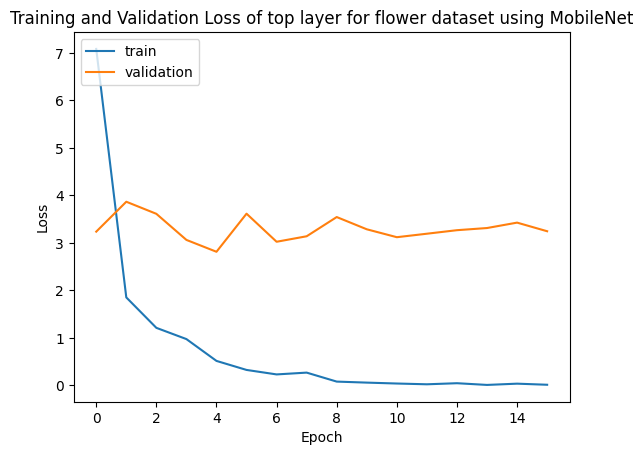

In [38]:
# Get the training and validation accuracy and loss from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('Training and Validation Accuracy of top layer for flower dataset using MobileNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Training and Validation Loss of top layer for flower dataset using MobileNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Magical Part (Car dataset using MobileNet)

In [39]:
# And a little bit different coding approach
# Load the MobileNet model, pre-trained on ImageNet
base_model_c = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model_c.layers:
    layer.trainable = False

# Add a new dense layer for classification
x = base_model_c.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model_c.input, outputs=predictions)

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.4, momentum=0.7)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train the model
history = model.fit(train_set, epochs=16, validation_data=valid_set)

Epoch 1/16
86/86 [==============================] - 6s 52ms/step - loss: 8.8293 - accuracy: 0.7867 - val_loss: 5.8914 - val_accuracy: 0.8058
Epoch 2/16
86/86 [==============================] - 3s 40ms/step - loss: 1.9906 - accuracy: 0.9055 - val_loss: 3.2770 - val_accuracy: 0.8711
Epoch 3/16
86/86 [==============================] - 3s 38ms/step - loss: 1.2134 - accuracy: 0.9255 - val_loss: 5.5053 - val_accuracy: 0.8076
Epoch 4/16
86/86 [==============================] - 4s 46ms/step - loss: 1.0150 - accuracy: 0.9324 - val_loss: 3.9411 - val_accuracy: 0.8802
Epoch 5/16
86/86 [==============================] - 3s 40ms/step - loss: 0.9954 - accuracy: 0.9382 - val_loss: 4.9413 - val_accuracy: 0.8512
Epoch 6/16
86/86 [==============================] - 3s 40ms/step - loss: 0.5042 - accuracy: 0.9604 - val_loss: 3.8115 - val_accuracy: 0.8675
Epoch 7/16
86/86 [==============================] - 3s 40ms/step - loss: 0.2137 - accuracy: 0.9793 - val_loss: 4.0045 - val_accuracy: 0.8730
Epoch 8/16
86

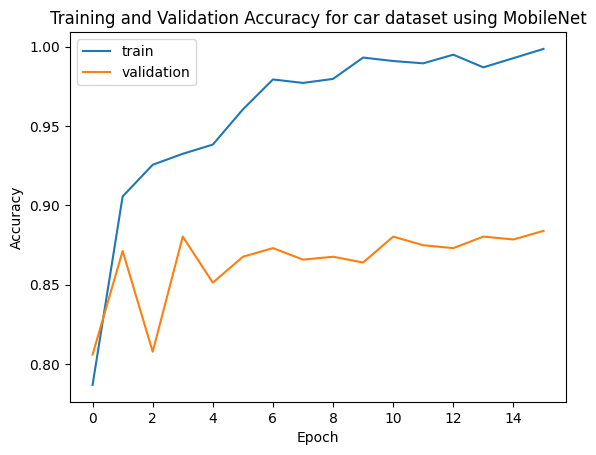

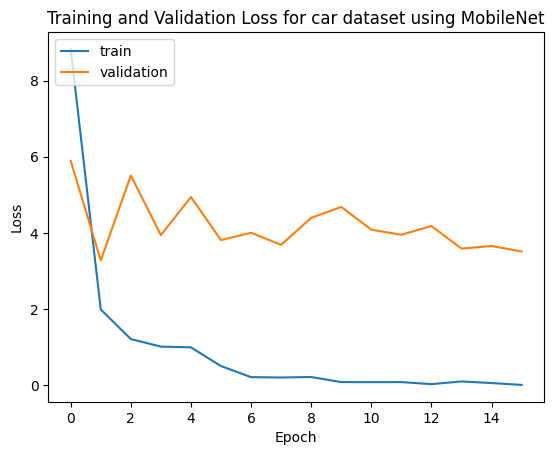

In [40]:
# Get the training and validation accuracy and loss from the history object
training_accuracy_c = history.history['accuracy']
validation_accuracy_c = history.history['val_accuracy']
training_loss_c = history.history['loss']
validation_loss_c = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(training_accuracy_c)
plt.plot(validation_accuracy_c)
plt.title('Training and Validation Accuracy for car dataset using MobileNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(training_loss_c)
plt.plot(validation_loss_c)
plt.title('Training and Validation Loss for car dataset using MobileNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Conclusion

1.   By increasing the learning rate from 0.2 to 0.4 in MobileNet, we noticed a **drop** in **validation loss**. 
2.   As MobileNet is trained on more number of parameters compared to Xception, it performerd better than Xception. MobileNet gave better accuracy score for both **Flower** and **Car** Datasets.
3. It also took less time to train the model.

